In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense ,Dropout, BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import time
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import pickle

from google.colab import files
uploaded= files.upload()

# Load the data into a pandas DataFrame called df
df=pd.read_csv('Water_dataX_mean_state_hong_kong.csv')


Saving Water_dataX_mean_state_hong_kong.csv to Water_dataX_mean_state_hong_kong.csv


In [ ]:
#df.head(1)

In [2]:
#df.head(1)
def choice_of_zone_river_station (df) : 
  df=df[['water control zone','river','station','dates','wqi']]

  B = set(df['water control zone'])
  print('choisir votre zone parmi : ')    
  print(B)
  zone=input()

  C = set(df[df['water control zone']==zone]['river'])
  print('choisir votre rivier parmi ')
  print(C)
  river=input()

  D=set(df[df['river']==river]['station'])
  print('choisis votre station parmi :')
  print(D)
  station=input()

  data = df[['dates', 'wqi']][(df['water control zone'] ==zone) & (df['river'] == river) & (df['station'] == station)]
  data.to_csv('data1.csv', index=False)
  
  # Load the data into a pandas DataFrame called df
  df_selected = pd.read_csv('data1.csv', index_col=0, parse_dates=True)
  zone_river_station = {"Selected zone = ": zone, "Selected river = ": river, "Selected station = ": station}

  return df_selected, zone_river_station

def Split_into_train_test (data_selected, coef) : 

  # Scale the data using MinMaxScaler
  scaler = MinMaxScaler()
  scaled_data = scaler.fit_transform(data_selected.values.reshape(-1, 1))

  # Split the data into training and testing sets
  train_size = int(len(scaled_data) * coef)
  train_data = scaled_data[:train_size, :]
  test_data = scaled_data[train_size:, :]

  return train_data, test_data, scaler, scaled_data

# Define a function to create sequences of data 
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Build the CNN model
def CNN_model(X_train) :
  model = Sequential()
  model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=1))
  model.add(BatchNormalization())
  model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
  model.add(MaxPooling1D(pool_size=1))
  model.add(BatchNormalization())
  model.add(Conv1D(filters=128, kernel_size=1, activation='relu'))
  model.add(MaxPooling1D(pool_size=1))
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(Dense(units=128, activation='relu'))
  model.add(Dense(units=1, activation='linear'))
  return model

# Define the LSTM model
def LSTM_model(X_train) :
  model = Sequential()
  model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  model.add(LSTM(units=50, return_sequences=True))
  model.add(LSTM(units=50))
  model.add(Dropout(0.1))
  model.add(Dense(units=1))
  return model

def ARIMA_model(data_selected) :

  # Create an ARIMA model with order (1, 3, 2)
  model = sm.tsa.arima.ARIMA(data_selected['wqi'], order=(5, 1, 0))
  #model = sm.tsa.arima.ARIMA(data_selected['wqi'], order=(1, 1, 2))
  
  return model

def Choice_of_model () :
  models = {'CNN', 'LSTM', 'ARIMA'}
  print('choisir un modèle parmi : ')    
  print(models)

  choix_model=input()

  return choix_model

# Définir un callback pour mesurer les temps de chaque étape
step_times = []
class TimingCallback(tf.keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
        self.start_time = time.time()

    def on_train_batch_end(self, batch, logs=None):
        step_time = time.time() - self.start_time
        step_times.append(step_time)

def run_model (choix_model, X_train, y_train, X_test, y_test, batch_size, epochs) : 

  # Train the model
  # Début du chrono
  start_time = time.time()
  # Enregistrer les temps de départ

  # Train the model
  if (str(choix_model)== 'ARIMA') :     
    model = ARIMA_model(data_selected)
    model = model.fit()
    # save model
    model.save('model.pkl')
    history = model # a modifier
  elif (choix_model== 'CNN') :
    model = CNN_model(X_train)
    model.compile(optimizer='adam',loss='mse')
    history=model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_test, y_test),callbacks=[TimingCallback()])
    model.save('forcasting_hong_kong_'+str(choix_model)+'.h5')
  elif (choix_model== 'LSTM') :
    model = LSTM_model(X_train)
    model.compile(optimizer='adam',loss='mse')
    history=model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_test, y_test),callbacks=[TimingCallback()])
    model.save('forcasting_hong_kong_'+str(choix_model)+'.h5')
  else : 
    print("choix erroné !! ")   

  # Fin du chrono
  end_time = time.time()

  # Calcul de la durée d'entraînement en secondes
  training_time = end_time - start_time

  return model, history, training_time

def prediction_on_test_data (choix_model, model) :
  prediction =[]
  # Make predictions on the test data
  if (str(choix_model)== 'ARIMA') :
    #model = ARIMAResults.load('model.pkl')
    with open('model.pkl', 'rb') as pkl:
      prediction = pickle.load(pkl).predict(start=data_selected.index[seq_length])
  else :
    x_t = []
    for i in range(seq_length, len(scaled_data)):
      x_t.append(scaled_data[i-seq_length:i, :])
    x_t = np.array(x_t)
    prediction = model.predict(x_t)
    # Rescale the data back to the original scale
    prediction = scaler.inverse_transform(prediction)

  return prediction

def run_models (X_train, y_train, X_test, y_test, batch_size, epochs) :
  predictions = dict()
  MSE = dict()
  CPU_time = dict()
  histories = dict()

  models = {'CNN', 'ARIMA', 'LSTM'}
  for choice in models :
    if (choice == 'CNN') :
      print ('************** '+ str(choice) + ' model is running ********* : ')
      model, history, training_time = run_model (choice, X_train, y_train, X_test, y_test, batch_size, epochs) 
      predictions [choice] = prediction_on_test_data (choice, model)
      # la durée d'entraînement
      CPU_time [choice] = training_time
      #Calculate the MSE
      mse = mean_squared_error(data_selected[seq_length:len(data_selected)],predictions[choice])
      MSE[choice] = mse
      histories[choice] = history 
    elif (choice == 'LSTM') :
      print ('************** '+ str(choice) + ' model is running ********* : ')
      model, history, training_time = run_model (choice, X_train, y_train, X_test, y_test, batch_size, epochs)
      predictions [choice] = prediction_on_test_data (choice, model)
      #la durée d'entraînement
      CPU_time [choice] = training_time
      #Calculate the MSE
      mse = mean_squared_error(data_selected[seq_length:len(data_selected)],predictions[choice])
      MSE[choice] = mse
      histories[choice] = history 
    elif (choice == 'ARIMA') :
      print ('************** '+ str(choice) + ' model is running ********* : ')
      model, history, training_time = run_model (choice, X_train, y_train, X_test, y_test, batch_size, epochs) 
      res = np.array(prediction_on_test_data (choice, model).values)
      predictions [choice] = res 
      #la durée d'entraînement
      CPU_time [choice] = training_time
      #Calculate the MSE
      mse = mean_squared_error(data_selected[seq_length:len(data_selected)],predictions[choice])
      MSE[choice] = mse
      histories[choice] = history 
    else : 
      print("choix erroné !! ")

  return predictions, MSE, CPU_time, histories

def plot_predictions (predictions) :

  fig, ax = plt.subplots(3, 1, figsize=(12, 10) , height_ratios=[2, 2, 2])
  fig.subplots_adjust(hspace=0.3)

  # Data observed 
  y_observed = scaler.inverse_transform(scaled_data[seq_length:len(scaled_data)])
  
  # Tracer les valeurs observées et prédites
  models = {0:'LSTM', 1:'ARIMA', 2:'CNN'}
  for i in models.keys() : 
    ax[i].plot(data_selected.index[seq_length:], y_observed, label='Observed')
    ax[i].plot(data_selected.index[seq_length:], predictions[models[i]], label='Predicted')
    ax[i].set_title('Prediction with '+str(models[i]) + ' model', fontsize=16, color='blue')
    ax[i].set_ylabel('WQI')
    ax[i].legend()

  plt.show() 

############
data_selected, zone_river_station = choice_of_zone_river_station(df)
train_data, test_data, scaler, scaled_data = Split_into_train_test (data_selected, 0.8)
train_size = train_data.shape[0]

# Create sequences of data
seq_length = 30
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

choisir votre zone parmi : 
{'Port Shelter', 'Western Buffer', 'North Western', 'DB4', 'Tolo Harbour And Channel', 'Southern', 'Deep Bay', 'Victoria Harbour', 'DB7', 'Junk Bay'}
Tolo Harbour And Channel
choisir votre rivier parmi 
{'Siu Lek Yuen Nullah', 'Lam Tsuen River', 'Shan Liu Stream', 'Tai Po River', 'Kwun Yam Shan Stream', 'Tin Sum Nullah', 'Tung Tze Stream', 'Tai Po Kau Stream', 'Tai Wai Nullah', 'Shing Mun River'}
Kwun Yam Shan Stream
choisis votre station parmi :
{'KY1'}
KY1


************** CNN model is running ********* : 
Epoch 1/200
9/9 [==============================] - 2s 45ms/step - loss: 3.6689 - val_loss: 0.0618
Epoch 2/200
9/9 [==============================] - 0s 26ms/step - loss: 0.0713 - val_loss: 0.0608
Epoch 3/200
9/9 [==============================] - 0s 21ms/step - loss: 0.0574 - val_loss: 0.0597
Epoch 4/200
9/9 [==============================] - 0s 22ms/step - loss: 0.0526 - val_loss: 0.0574
Epoch 5/200
9/9 [==============================] - 0s 34ms/step - loss: 0.0426 - val_loss: 0.0535
Epoch 6/200
9/9 [==============================] - 0s 39ms/step - loss: 0.0331 - val_loss: 0.0488
Epoch 7/200
9/9 [==============================] - 0s 33ms/step - loss: 0.0276 - val_loss: 0.0450
Epoch 8/200
9/9 [==============================] - 0s 34ms/step - loss: 0.0231 - val_loss: 0.0430
Epoch 9/200
9/9 [==============================] - 0s 36ms/step - loss: 0.0204 - val_loss: 0.0414
Epoch 10/200
9/9 [==============================] - 0s 34ms/step - lo

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Epoch 1/200
9/9 [==============================] - 9s 336ms/step - loss: 0.0251 - val_loss: 0.0182
Epoch 2/200
9/9 [==============================] - 1s 108ms/step - loss: 0.0163 - val_loss: 0.0165
Epoch 3/200
9/9 [==============================] - 1s 88ms/step - loss: 0.0145 - val_loss: 0.0162
Epoch 4/200
9/9 [==============================] - 1s 86ms/step - loss: 0.0145 - val_loss: 0.0152
Epoch 5/200
9/9 [==============================] - 1s 85ms/step - loss: 0.0148 - val_loss: 0.0145
Epoch 6/200
9/9 [==============================] - 1s 89ms/step - loss: 0.0140 - val_loss: 0.0146
Epoch 7/200
9/9 [==============================] - 1s 89ms/step - loss: 0.0147 - val_loss: 0.0143
Epoch 8/200
9/9 [==============================] - 1s 90ms/step - loss: 0.0149 - val_loss: 0.0143
Epoch 9/200
9/9 [==============================] - 1s 85ms/step - loss: 0.0142 - val_loss: 0.0144
Epoch 10/200
9/9 [==============================] - 1s 87ms/step - loss: 0.0141 - val_loss: 0.0144
Epoch 11/200
9/9 

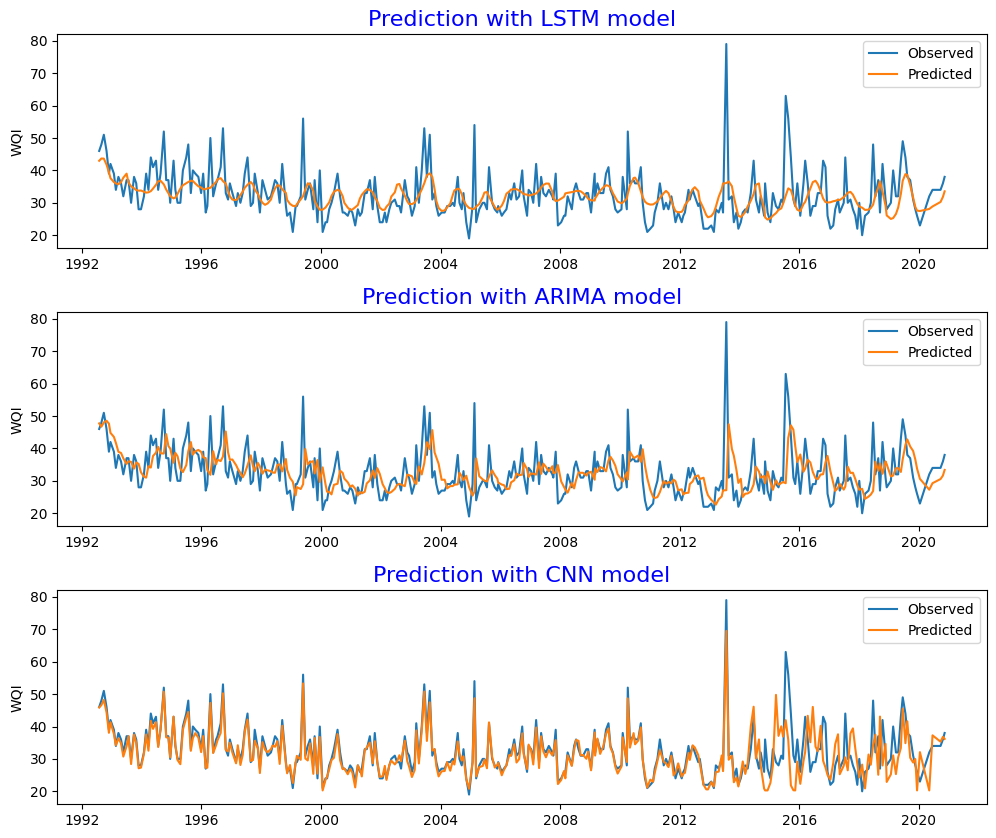

######## Test on the selected data ###### :
{'Selected zone = ': 'Tolo Harbour And Channel', 'Selected river = ': 'Kwun Yam Shan Stream', 'Selected station = ': 'KY1'}
*********************************
CPU time of CNN model :  83.83274984359741 secondes
CPU time of ARIMA model :  0.13813281059265137 secondes
CPU time of LSTM model :  208.00365805625916 secondes
*********************************
Mean Square Erreur of CNN model: 20.148456478292648
Mean Square Erreur of ARIMA model: 54.479663939978614
Mean Square Erreur of LSTM model: 41.03762295455109


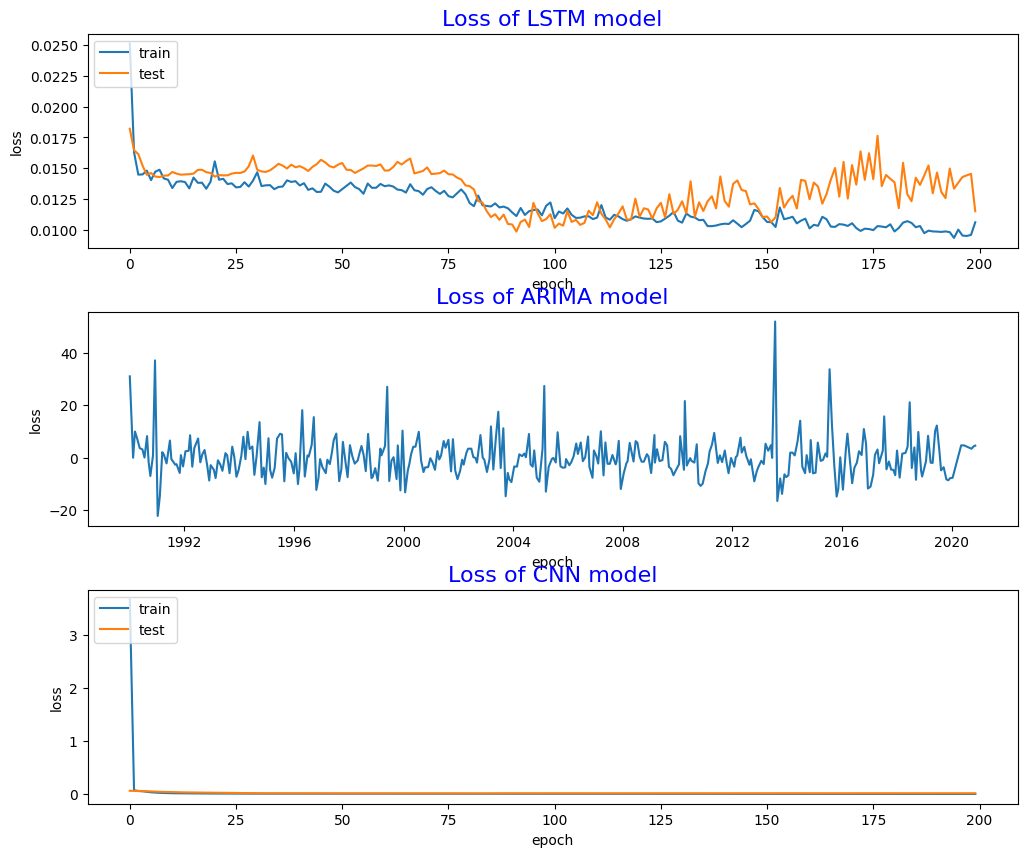

In [4]:
#model, choix_model = Choice_of_model ()

predictions, MSE, CPU_time, histories = run_models (X_train, y_train,  X_test, y_test, batch_size=32,  epochs = 200)
plot_predictions (predictions)

print("######## Test on the selected data ###### :" )
print(zone_river_station)

models = {'ARIMA', 'LSTM', 'CNN'}
print('*********************************')
for choice in models :
  print("CPU time of "+ str(choice)+ " model : ", CPU_time [choice], "secondes")
print('*********************************')  
for choice in models :
  print('Mean Square Erreur of ' + str(choice)+ ' model:', MSE[choice])

  #print('History ' + str(choice)+ ' model:', histories[choice])

fig, ax = plt.subplots(3, 1, figsize=(12, 10) , height_ratios=[2, 2, 2])
fig.subplots_adjust(hspace=0.3)

models = {0:'LSTM', 1:'ARIMA', 2:'CNN'}
from pandas import DataFrame

for i in models.keys()  :
  #print(histories[choice].history.keys())
  if (i==1) :
    ax[i].plot(DataFrame(histories['ARIMA'].resid)) ## vérifier l'équivalence entre residu d'Arima et loss de CNN et LSTN 
  else : 
    ax[i].plot(histories[models[i]].history['loss'])
    ax[i].plot(histories[models[i]].history['val_loss'])
    ax[i].legend(['train', 'test'], loc='upper left')

  ax[i].set_title('Loss of '+ str(models[i])+ ' model', fontsize=16, color='blue')
  ax[i].set_ylabel('loss')
  ax[i].set_xlabel('epoch')

plt.show()